In [1]:
import os
import gc
import cv2
import rasterio
import zipfile
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from multiprocessing import Pool
from rasterio.windows import Window
from torch.utils.data import Dataset

In [2]:
sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times 
MASKS = '../input/hubmap-kidney-segmentation/train.csv'

#TEST_MASK = '../input/hubmap-best-preds/hubmap_best_submission.csv'
#TEST_MASK = '../input/hubmap-0935-preds/hubmap_0.935_sub.csv'
TEST_MASK = '../input/256-bce-0931-my-preds-5-fold/5_fold_my_preds_0931.csv'

DATA = '../input/hubmap-kidney-segmentation/train/'
TEST_DATA = '../input/hubmap-kidney-segmentation/test/'

save_img_dir = "/kaggle/train_images/"
save_mask_dir = "/kaggle/train_masks/"
os.makedirs(save_img_dir, exist_ok=True)
os.makedirs(save_mask_dir, exist_ok=True)

In [3]:
df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [4]:
print(f"Number of train images: {df_masks.shape[0]}")

Number of train images: 15


In [5]:
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [6]:
df_test = pd.read_csv(TEST_MASK).set_index('id')
print(f"Number of test images: {df_test.shape[0]}")
df_test.head()

Number of test images: 5


,predicted
id,
2ec3f1bb9,60714325 7 60738299 37 60762282 49 60786267 58...
3589adb90,68600101 50 68629523 66 68658952 72 68688382 7...
d488c759a,548342233 15 548388883 36 548435537 49 5484821...
aa05346ff,52856695 27 52887405 44 52918117 57 52948831 6...
57512b7f1,281028083 1 281061321 6 281094560 13 281127799...


In [7]:
#functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, shape, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs


In [10]:
#https://www.kaggle.com/iafoss/256x256-images

s_th = 40  #saturation blancking threshold
p_th = 1000*(sz//256)**2 #threshold for the minimum number of pixels

class KidneyDataset(Dataset):
    def __init__(self, idx, reduce=reduce, encs=None, folder=DATA):
        self.data = rasterio.open(os.path.join(folder,idx+'.tiff'),num_threads='all_cpus')
        
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        self.reduce = reduce
        self.sz = reduce*sz
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0] + self.pad0)//self.sz
        self.n1max = (self.shape[1] + self.pad1)//self.sz
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        # the code below may be a little bit difficult to understand,
        # but the thing it does is mapping the original image to
        # tiles created with adding padding (like in the previous version of the kernel)
        # then the tiles are loaded with rasterio
        # n0,n1 - are the x and y index of the tile (idx = n0*self.n1max + n1)
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        x0,y0 = -self.pad0//2 + n0*self.sz, -self.pad1//2 + n1*self.sz

        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        mask = np.zeros((self.sz,self.sz),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_NEAREST)
        else:
            img = cv2.resize(img,(self.sz,self.sz),
                             interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz,self.sz),
                             interpolation = cv2.INTER_NEAREST)
            
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        #return -1 for empty images
        return img, mask, (-1 if (s>s_th).sum() <= p_th or img.sum() <= p_th else idx)

In [12]:
for image_id, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
    ds = KidneyDataset(image_id, encs=encs, folder=DATA)
    for i in range(len(ds)):
        im,m,idx = ds[i]
        save_image = save_img_dir + image_id + '_' + str(idx) + '.png'
        save_mask = save_mask_dir + image_id + '_' + str(idx) + '_mask' + '.npy'
        if idx < 0: continue
            
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_image, im)
        np.save(save_mask, m)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [13]:
for image_id, encs in tqdm(df_test.iterrows(),total=len(df_test)):
    ds = KidneyDataset(image_id, encs=encs, folder=TEST_DATA)
    for i in range(len(ds)):
        im,m,idx = ds[i]
        save_image = save_img_dir + image_id + '_' + str(idx) + '.png'
        save_mask = save_mask_dir + image_id + '_' + str(idx) + '_mask' + '.npy'
        if idx < 0: continue
            
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_image, im)
        np.save(save_mask, m)

In [14]:
print(len(ds))

1419


(256, 256, 3)
(256, 256)


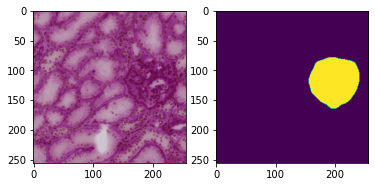

In [16]:
slice_num = 337

image = cv2.imread(f'/kaggle/train_images/d488c759a_{slice_num}.png')
print(image.shape)
m = np.load(f'/kaggle/train_masks/d488c759a_{slice_num}_mask.npy')
print(m.shape)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(m)

In [17]:
print(len(os.listdir('/kaggle/train_images/')))
print(len(os.listdir('/kaggle/train_masks/')))

13137
13137


In [18]:
!du -h /kaggle/train_images/

1.7G	/kaggle/train_images/


In [19]:
!du -h /kaggle/train_masks/

873M	/kaggle/train_masks/


In [20]:
!tar -czf train_images.tar.gz /kaggle/train_images/

tar: Removing leading `/' from member names


In [21]:
!tar -czf train_masks.tar.gz /kaggle/train_masks/

tar: Removing leading `/' from member names
